In [142]:
#Import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from visualize import feat_importance, rf_score_plot, plot_roc, hist_plt
from sklearn.ensemble import GradientBoostingRegressor


import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

In [140]:
df = pd.read_csv('train.csv')
df.head(1)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651


# EDA

In [141]:
df.corr()

,id,budget,popularity,runtime,revenue
id,1.000000,0.019732,-0.007470,0.010750,0.000610
budget,0.019732,1.000000,0.342356,0.238373,0.752965
popularity,-0.007470,0.342356,1.000000,0.133690,0.461460
runtime,0.010750,0.238373,0.133690,1.000000,0.216380
revenue,0.000610,0.752965,0.461460,0.216380,1.000000


In [67]:
def eda(df): 
    df.describe(include='all').T
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['release_year'] = df['release_date'].dt.year
    df['release_2000'] = np.where(df['release_year'] >= 2000, 1, 0)
    df = df[df.release_year <= 2019]
    df = df[['id','budget','popularity','runtime','revenue','release_2000']]
    df = df.dropna()
    return df

In [69]:
df = eda(df)

In [70]:
df.head()

,id,budget,popularity,runtime,revenue,release_2000
0,1,14000000,6.575393,93.0,12314651,1
1,2,40000000,8.248895,113.0,95149435,1
2,3,3300000,64.299990,105.0,13092000,1
3,4,1200000,3.174936,122.0,16000000,1
4,5,0,1.148070,118.0,3923970,1


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2852 entries, 0 to 2999
Data columns (total 6 columns):
id              2852 non-null int64
budget          2852 non-null int64
popularity      2852 non-null float64
runtime         2852 non-null float64
revenue         2852 non-null int64
release_2000    2852 non-null int32
dtypes: float64(2), int32(1), int64(3)
memory usage: 144.8 KB


# Split and Scale

In [56]:
y = df.pop('revenue')
X= df

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=21)
scalar = StandardScaler().fit(X_train)
X_train_log = scalar.transform(X_train)
X_test_log = scalar.transform(X_test)

# Gridsearch

Random Forest

In [61]:
params = {
          'n_estimators': range(1,4), 
          'max_depth': range(1,4),
          'oob_score': ['True','False']
         }
rf_gs = GridSearchCV(RandomForestRegressor(), param_grid=params, cv=4, n_jobs=5).fit(X_train, y_train)
rf_gs

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'n_estimators': range(1, 4), 'max_depth': range(1, 4), 'oob_score': ['True', 'False']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [62]:
rf_model = RandomForestRegressor(**rf_gs.best_params_).fit(X_train,y_train)

In [63]:
mean_squared_error(y_test,rf_model.predict(X_test))**.5

88348570.96274875

Linear Regression 

In [118]:
regression=LinearRegression().fit(X_train, y_train)

In [119]:
mean_squared_error(y_test,regression.predict(X_test))**.5

83658112.30518234

Gradient Boosting

In [146]:
gradient_boosting_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
                          'max_depth': [2, 4, 6],
                          'min_samples_leaf': [1, 2, 5, 10],
                          'max_features': [1.0, 0.3, 0.1],
                          'n_estimators': [10],
                          'random_state': [1]}


gbr_gridsearch = GridSearchCV(GradientBoostingRegressor(),
                             gradient_boosting_grid,
                             verbose=True,
                             scoring='neg_mean_squared_error')
gbr_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:    4.4s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth': [2, 4, 6], 'min_samples_leaf': [1, 2, 5, 10], 'max_features': [1.0, 0.3, 0.1], 'n_estimators': [10], 'random_state': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=True)

In [147]:
best_gbr_model = gbr_gridsearch.best_estimator_

In [149]:
mean_squared_error(y_test, best_gbr_model.predict(X_test))**.5

93648094.26498702

# Test Data

In [84]:
def edatest(df): 
    df.describe(include='all').T
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['release_year'] = df['release_date'].dt.year
    df['release_2000'] = np.where(df['release_year'] >= 2000, 1, 0)
    #df = df[df.release_year <= 2019]
    df = df[['id','budget','popularity','runtime','release_2000']]
    return df

In [150]:
dft = pd.read_csv('test.csv')
dft = edatest(dft)

In [151]:
dft.runtime.fillna(dft.runtime.mean(), inplace=True)

In [152]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 5 columns):
id              4398 non-null int64
budget          4398 non-null int64
popularity      4398 non-null float64
runtime         4398 non-null float64
release_2000    4398 non-null int32
dtypes: float64(2), int32(1), int64(2)
memory usage: 154.7 KB


In [153]:
X = dft

# Random Forest Model

In [111]:
y_hat = rf_model.predict(X)

In [112]:
dft['revenue']= y_hat
dft = dft[['id','revenue']]

In [113]:
dft.to_csv('results')

Feature ranking:


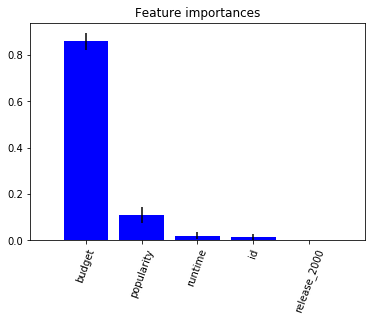

In [139]:
feat_importance(rf_model, X)

# Linear Regression Model

In [131]:
lry_hat = regression.predict(X)

In [132]:
dft['revenue']= lry_hat
dft = dft[['id','revenue']]

In [133]:
dft.to_csv('lr_results')

# Gradient Boosting Model

In [154]:
gby_hat = best_gbr_model.predict(X)

In [155]:
dft['revenue']= gby_hat
dft = dft[['id','revenue']]

In [156]:
dft.to_csv('gb_results')